In [3]:
import itertools
import random
import pandas as pd
import numpy as np
import lightgbm as lgb
from scipy import stats
from scipy.special import boxcox as boxcox_special, inv_boxcox
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.metrics import r2_score, mean_absolute_error

SEED = 13
random.seed(SEED)
np.random.seed(SEED)

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from IPython.display import clear_output
# https://www.statsmodels.org/devel/install.html
! pip install --upgrade Cython
! pip install --upgrade git+https://github.com/statsmodels/statsmodels
clear_output()

In [ ]:
# from pylab import rcParams
# rcParams['figure.figsize'] = 11, 9
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

##EDA

In [6]:
df = pd.read_excel('/content/drive/MyDrive/TZ/veeroute/Data данные.xlsx')
df = df.iloc[:, 0].str.split(',', expand=True)
df.columns = ['date', 'cash']
df['date'] = pd.to_datetime(df['date'])
df.cash = df.cash.astype('float').round(0).astype(np.int32)  #(6, 261475) (-2147483648, 2147483647)

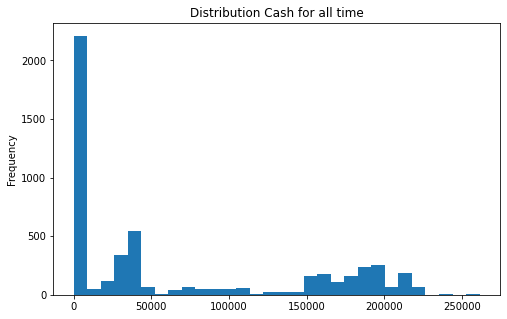

In [ ]:
df.cash.astype('float').plot(
    figsize=(8, 5),
    kind = 'hist',
    bins = 30,
    title = 'Distribution Cash for all time',
);

Большинство поступлений невелики, и находятся менее 50к.

Можно предположить, что основной костяк поступлений составляют небольшие суммы, но это не так, они составляют примерно 17%

Поступления между 100000 и 200000 составляют 61%, но они более редки и наконец поступления более 200000 составляют примерно 20%



In [ ]:
fig = go.Figure([go.Scatter(x=df['date'], y=df.rolling(14).mean().cash)])
fig.update_xaxes(
    rangeselector=dict(
        buttons=list([
            dict(count=14, label="14d", step="day", stepmode="todate"),
            dict(count=6, label="6m", step="month", stepmode="todate"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),    
            dict(step="all")
        ])
    )
)
fig.update_layout(
    title="14-days roll-mean Two Years Cash",
    xaxis_title="Dates",
    yaxis_title="Cash",
    font=dict(
        family="Courier New, monospace",
        size=16,
        color="RebeccaPurple"
    )
)
fig.show()

Можно заметить, что рост это крупные поступления за ним идет падение, крупные поступления не повторяются, тем не менее видна некая закономерность, что в июле 2018 и 19  были крупные поступления, и напротив в апреле и октябре просматривается наименьшее поступления.

add time

In [ ]:
def time_features(df: pd.DataFrame) -> None:
    df.date = pd.to_datetime(df.date, utc=True)
    attr = [       
            'day',
            'month',
            'week',
            "dayofweek",
            "year",
            'quarter'
            ]    
    for at in attr:
        dtype = np.int16 if at == "year" else np.int8
        df[at] = getattr(df.date.dt, at).astype(dtype)
time_features(df)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



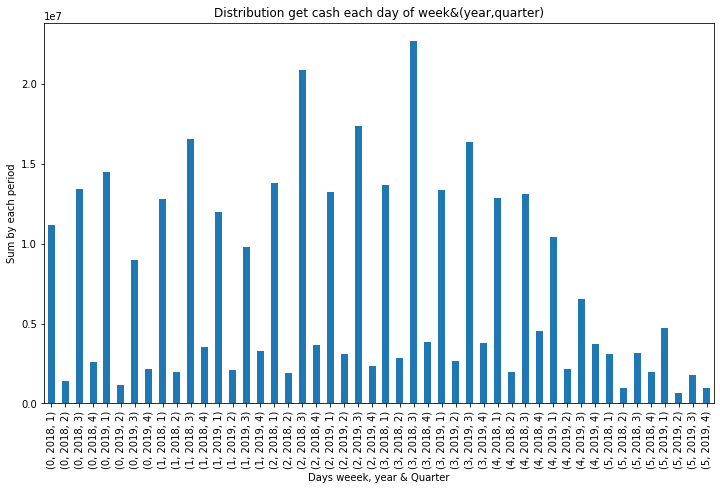

In [ ]:
df.groupby(['dayofweek', 'year', 'quarter'])['cash'].sum().plot(
    kind='bar',
    figsize=(12, 7),
    xlabel='Days weeek, year & Quarter',
    ylabel='Sum by each period',
    title='Distribution get cash each day of week&(year,quarter)'
)

Тут стоит отметить, что 2 и 4 квартал, как отмечалось ранее имеет наименьшее кол-во поступлений, наибольшие поступления в 1 и 3 квартале, стоит отметить рост поступлений к середине недели и спад в конце.


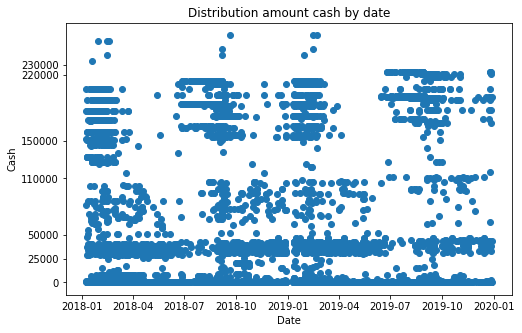

In [ ]:
df['clear_date'] = df.date.dt.date

plt.figure(figsize=(8, 5))
plt.scatter(df.clear_date, df.cash)
plt.title('Distribution amount cash by date')
plt.xlabel('Date')
plt.ylabel('Cash')
plt.yticks(
    [0,
     25000,
     50000,
     110000,
     150000,
     220000,
     230000
     ]
);

Вот именно этот график сыграл злую шутку первой версии ноутбука, здесь отчетливо видно, как распределены поступления, это и привело к мысли разбить их на группы.

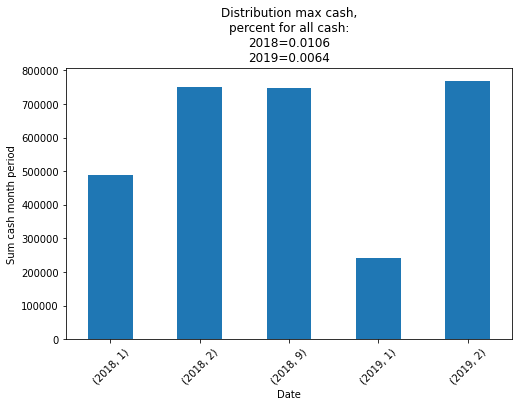

In [ ]:
df_max_cash = df[df['cash'] > 230000][['clear_date','year', 'cash', 'month']].reset_index(drop=True)
yall =df.groupby('year')['cash'].sum()
ynotmax = df[df['cash'] < 230000].groupby('year')['cash'].sum()
percent_amount_max_cash = 1- ynotmax/yall

df_max_cash.groupby(['year', 'month'])['cash'].sum().plot(
    kind='bar',
    figsize=(8, 5),
    xlabel='Date',
    ylabel='Sum cash month period',
    title=f'Distribution max cash,\npercent for all cash:\n2018={np.round(percent_amount_max_cash.values[0], 4)}\n2019={np.round(percent_amount_max_cash.values[1], 4)}',
     rot=45
);

In [ ]:
del df

##Features&model

С самого начала я сделал ошибку в том, что я сделай фиктивные данные. Ошибка в том, что я получил хорошие значения на валидации, но я не мог оценить фиктивные так там нет таргета, в итоге много времени просто потрачено зря, в связи с незнанием сроков сдачи задания я оставлю, как есть с исключением фиктивных данных из модели и взяв настоящие данные изменив в них таргет на 0..

make features

In [ ]:
def make_data(path: str, test_start: str, fill_test: int = 0) -> tuple:
    """
    path : str path to data file
    test_start: date when start test

    for test we set cash to zero

    return: pd.DataFrame,  index satrt test, original label to test not changed   
    """
    col_name = ['date', 'cash']
    df = pd.read_excel(path)
    df = df.iloc[:, 0].str.split(',', expand=True)   
    df.columns =  col_name
    df['date'] = pd.to_datetime(df['date'])
    df['clear_date'] = df.date.dt.date
    df.cash = df.cash.astype('float32')
    test_label = df[df.clear_date.astype('str') > test_start].cash.values
    idx_test = df[df.clear_date.astype('str') <= test_start].shape[0]
    df.loc[df.clear_date.astype('str') > test_start, 'cash'] = fill_test
    df.cash = df.cash.astype('float32')
    return df, idx_test, test_label


d_test = '2019-12-11'
path = '/content/drive/MyDrive/TZ/veeroute/Data данные.xlsx'
df, idx_test, test_label = make_data(path, d_test, 1)
df.tail()

,date,cash,clear_date
5163,2019-12-27 11:42:17+00:00,1.0,2019-12-27
5164,2019-12-27 14:01:55+00:00,1.0,2019-12-27
5165,2019-12-28 13:24:11+00:00,1.0,2019-12-28
5166,2019-12-28 13:26:05+00:00,1.0,2019-12-28
5167,2019-12-28 16:07:02+00:00,1.0,2019-12-28


In [ ]:
time_features(df)
# df['clear_date'] = df.date.dt.date

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



In [ ]:
df['hour'] = df.date.dt.hour
# df['mean_hour'] = df.groupby(['clear_date', 'hour'])['cash'].transform('mean')
df['median_hour'] = df.groupby(['clear_date', 'hour'])['cash'].transform('median')
df['mean_hour_shift'] = df.groupby(['clear_date', 'hour'])['cash'].transform('mean').shift(91)

# df['sum_each'] = df.groupby(['clear_date'])['cash'].transform('sum')
# df['mean/sum'] = df['mean_hour_shift'] / df['sum_each']

df['ewm_trebd_var']  = df.median_hour.ewm(alpha=0.5, adjust=False).var()

# df['moments'] = df['median_hour'] / df.groupby(['clear_date', 'hour'])['cash'].transform(lambda x: x.shift(1).median())
df['counts_cash'] = df.groupby(['clear_date'])['cash'].transform('count')
# df['moment_counts'] = df['counts_cash'] / df['counts_cash'].shift(1) #0.05



# df['count/mean'] = df.counts_cash / df.mean_hour_shift

In [ ]:
df['minn'] = df.groupby(['clear_date', 'hour'])['cash'].transform(lambda x: x.min()).shift(90)
df['maxx'] = df.groupby(['clear_date', 'hour'])['cash'].transform(lambda x: x.max()).shift(91)
df['std'] = df.groupby(['clear_date'])['mean_hour_shift'].transform('std')
df['min/maxx'] = df.groupby(['clear_date'])['mean_hour_shift'].transform(lambda x: x.min() / 1 + x.max())

In [ ]:
# b = int(np.floor(1 + np.log2(len(df))))
# l = range(13)
# df['bin_cash'] = pd.cut(df['ewm_trebd_var'], bins=b,labels=l, include_lowest=True)

for i in [7, 14, 28, 30, 60, 90]:
    print('Rolling period:', i)
    df['rolling_mean_'+str(i)] = df.groupby(['clear_date', 'hour'])['cash'].transform(lambda x: x.mean()).shift(i)
    df['rolling_std_'+str(i+1)]  = df.groupby(['clear_date', 'hour'])['cash'].transform(lambda x: x.std()).shift(i)

# for d_shift in [14, 21, 28, 42, 56, 90, 120]: 
#     print('Shifting period:', d_shift)
#     for d_window in [1]:
#         col_name = 'rolling_mean_tmp_'+str(d_shift)+'_'+str(d_window)
#         df[col_name] = df.groupby(['clear_date', 'hour'])['cash'].transform(lambda x: x.rolling(d_window).mean()).shift(d_shift)
#         # df[col_name] = df.groupby(['clear_date', 'hour'])['cash'].transform('mean').rolling(d_window).mean().shift(d_shift)

# p1 = df.groupby(['year','month','week'])['cash'].transform('mean')
# p2  = df.groupby(['year', 'month','week', 'day'])['cash'].transform('mean')
# df['trend_days'] = p2-p1 # 0.009
df.fillna(0, inplace=True)

Rolling period: 7
Rolling period: 14
Rolling period: 28
Rolling period: 30
Rolling period: 60
Rolling period: 90


make data to model

In [25]:
def make_data_train(
    df: pd.DataFrame,
    test_label: list,
    drop_col, ratio: float,
    split_valid: bool = False
) -> tuple:
    data = df.drop(drop_col, axis = 1)
    label = df.iloc[:idx_test].cash.values
    data = data.iloc[:idx_test]    
    tr_size = int(data.shape[0] * ratio)
    tr = data.iloc[:tr_size]
    tr_y = label[:tr_size]
    idx_vl = idx_test - tr_size
    if split_valid:
        vl = data.iloc[tr_size:tr_size + int(idx_vl/2)].reset_index(drop=True)
        vl_y = label[tr_size:tr_size + int(idx_vl/2)]
        
        vl2 = data.iloc[tr_size + int(idx_vl/2):].reset_index(drop=True)
        vl2_y = label[tr_size + int(idx_vl/2):]
    else:
        vl2, vl2_y = None, None
        vl = data.iloc[tr_size:tr_size + idx_vl].reset_index(drop=True)
        vl_y = label[tr_size:tr_size + idx_vl]
        #make test
    test = df.iloc[idx_test:].drop(drop_col, axis = 1).reset_index(drop=True)
    test_y = test_label.astype(float)
    print(tr.shape, tr_y.shape, vl.shape, vl_y.shape, test.shape, test_y.shape)
    return tr, tr_y, vl, vl_y, vl2, vl2_y, test, test_y

In [ ]:
drop = ['clear_date', 'date', 'cash','week', 'year']
tr, tr_y, vl, vl_y, vl2, vl2_y, test, test_y = make_data_train(df, test_label, drop, 0.8, True)

(4049, 25) (4049,) (506, 25) (506,) (106, 25) (106,)


train model

In [ ]:
lgb_params = {
    'num_iterations': 1500,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'bagging_fraction': 0.5,
    'subsample_freq': 1,
    'learning_rate':0.03,
    'feature_fraction': 0.5,
    'verbose': -1,
    'early_stopping_round': 50

    }
lgb_params['seed'] = SEED
tr_data = lgb.Dataset(tr, label= tr_y)
tr_data.save_binary('train_data.bin')
tr_data = lgb.Dataset('/content/train_data.bin')
vl_data = lgb.Dataset(vl, label= vl_y)

model = lgb.train(
    lgb_params,
    tr_data,
    valid_sets = [tr_data, vl_data],
    verbose_eval = 100,
)
# lgb.plot_importance(model, figsize=(15,15))
!rm '/content/train_data.bin'

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



Training until validation scores don't improve for 50 rounds.
[100]	training's l1: 6.91919	valid_1's l1: 6.7359
[200]	training's l1: 6.38419	valid_1's l1: 6.40643
[300]	training's l1: 5.96018	valid_1's l1: 6.27346
Early stopping, best iteration is:
[305]	training's l1: 5.94112	valid_1's l1: 6.26795


##Results

Основная проблема, это то, что модель видит только features основанные на среднем значение и соответственно она его предсказывает, у нас же значения прыгают в широком диапазоне, а мы фактически предсказываем среднее , но поскольку нам нужно предсказать 14 дней то я объединил значения по дате это привело к более менее приемлемым результатам для валидации. Чего не сказать о тесте.

valid

In [ ]:
y_ = model.predict(vl2)
mae = mean_absolute_error(vl2_y, y_)
r2 = r2_score(vl2_y, y_)
print('Result predict model on test data Rsquare: %.3f, mae: %.1f' % (r2, mae))

Result predict model on test data Rsquare: 0.122, mae: 7.5


In [ ]:
data = df.iloc[:idx_test]
tr_size = int(data.shape[0] * 0.8)
idx_vl = idx_test - tr_size
df_test = data.iloc[tr_size + int(idx_vl/2):].reset_index(drop=True)[['cash','clear_date']]
df_test['predict'] = y_

In [ ]:
r2_score(df_test.groupby('clear_date').sum().cash.values,
         df_test.groupby('clear_date').sum().predict.values)

0.9921203515323652

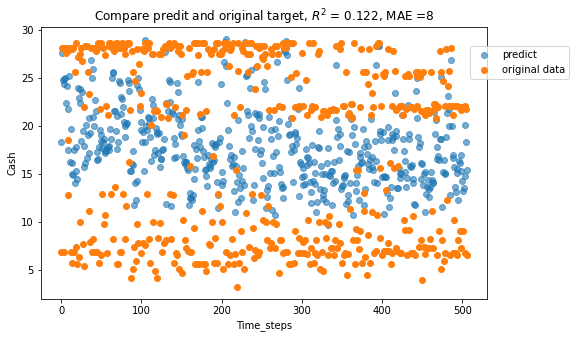

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(range(len(y_)), y_, alpha = 0.6, label='predict')
plt.scatter(range(len(vl2_y)), vl2_y, label = 'original data')
plt.title(f'Compare predit and original target, $R^2$ = {round(r2, 3)}, MAE ={round(mae)}')
plt.ylabel('Cash')
plt.xlabel('Time_steps')
plt.legend(loc=2, bbox_to_anchor=(0.95,0.95))

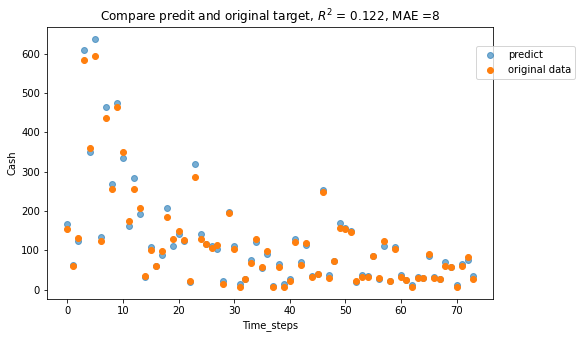

In [ ]:
plt.figure(figsize=(8, 5))
plt.scatter(range(len(df_test.groupby('clear_date').sum().predict.values)), df_test.groupby('clear_date').sum().predict.values, alpha = 0.6, label='predict')
plt.scatter(range(len(df_test.groupby('clear_date').sum().cash.values)), df_test.groupby('clear_date').sum().cash.values, label = 'original data')
plt.title(f'Compare predit and original target, $R^2$ = {round(r2, 3)}, MAE ={round(mae)}')
plt.ylabel('Cash')
plt.xlabel('Time_steps')
plt.legend(loc=2, bbox_to_anchor=(0.95,0.95))

test result

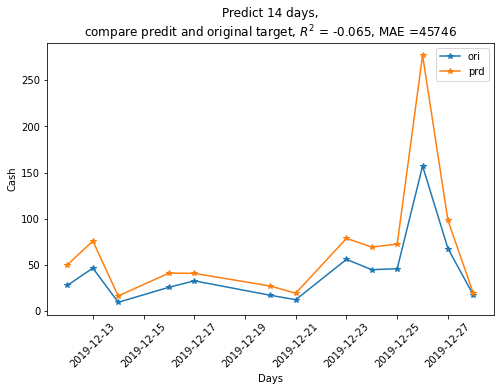

In [ ]:
y_ = model.predict(test)
df_test = df[idx_test:][['clear_date']].reset_index(drop=True)
df_test['ori'] = test_y
df_test['prd'] = abs(y_.astype(float))
ori_label = df_test.groupby('clear_date').ori.sum()
pred_label = df_test.groupby('clear_date').prd.sum()

r2_sum = r2_score(ori_label,pred_label)
mae = mean_absolute_error(test_y, y_)
df_test.groupby('clear_date').sum().plot(
    figsize=(8, 5),
    style = '-*',
    xlabel='Days',
    ylabel='Cash',
    title=f'Predict 14 days,\ncompare predit and original target, $R^2$ = {round(r2_sum, 3)}, MAE ={round(mae)}',
    rot=45
);

In [ ]:
pred_label

clear_date
2019-12-12     49.930553
2019-12-13     75.737385
2019-12-14     16.076027
2019-12-16     40.885244
2019-12-17     40.621000
2019-12-20     26.854653
2019-12-21     19.073506
2019-12-23     78.591252
2019-12-24     69.151429
2019-12-25     72.370976
2019-12-26    277.383855
2019-12-27     98.099021
2019-12-28     18.949721
Name: prd, dtype: float64

In [ ]:
ori_label

clear_date
2019-12-12     27.669997
2019-12-13     46.320800
2019-12-14      9.235072
2019-12-16     25.511852
2019-12-17     32.504667
2019-12-20     16.824239
2019-12-21     12.022522
2019-12-23     55.802788
2019-12-24     44.549909
2019-12-25     45.734262
2019-12-26    157.161809
2019-12-27     67.574784
2019-12-28     17.189797
Name: ori, dtype: float64

Среднее предсказанное моделью и оригинальные данные

In [ ]:
df_test['prd'].mean(),df_test['prd'].sum(), df_test['ori'].mean(), df_test['ori'].sum()

(8.337024727202104, 883.7246210834226, 5.26511790967149, 558.1024984251777)

Среднее предыдущих 14 дней перед тестом

In [ ]:
df.iloc[idx_test- 106:idx_test].cash.mean(), df.iloc[idx_test- 106:idx_test].cash.sum()

(16.237838745117188, 1721.2104)

Среднее, что предсказала модель 12911, общая сумма за 14 дней 1368605, оригинальные данные дают следующие цифры 45754 и 4850012.

Среднее за предыдущие 14 дней до теста 39015 и 4135657, это то что нужно было улучшить.

В итоге среднее предыдущих 14 дней лучше чем предсказанное моделью.


Я думаю, что основная  проблема у данной модели  это то, что почти все features основаны на среднем или медиане это не позволяет предсказывать так сказать выбросы(крупные поступления) мы просто все сглаживаем.

Хочу попробовать:
- увеличить размер данных
- заполнить  тестовые данные не 0 а значениями за 18 год за этот же промежуток времени


#Research


## make duplicate data

In [ ]:
def make_clone(data: pd.DataFrame, sub: int) -> pd.DataFrame:
    clone_df = data.copy()
    clone_df['date'] = pd.to_datetime(
    dict(
        year=clone_df.date.dt.year.subtract(sub),
        month=clone_df.date.dt.month,
        day = clone_df.date.dt.day,
        hour = clone_df.date.dt.hour
        )
    )
    return clone_df

In [ ]:
clone_df = df.copy()
clone_df['year'] = clone_df.date.dt.year
clone_df = clone_df[clone_df.year == 2018]
clone_df.drop(['year', 'clear_date'], axis=1, inplace=True)

d16 = make_clone(clone_df, 2)
d17 = make_clone(clone_df, 1)
df = pd.concat(
    [d16, d17, df],
    axis =0
).reset_index(drop=True)
df.shape

idx_test = 11097

не хочу дублировать тотже код что и выше могу сказать что сильно ничего не поменялось

##make fill data cash from previous period

fiil data

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/TZ/veeroute/Data данные.xlsx')
df = df.iloc[:, 0].str.split(',', expand=True)
df.columns = ['date', 'cash']
df['date'] = pd.to_datetime(df['date'])
df['clear_date'] = df.date.dt.date
time_features(df)

cash18 = df[df.year == 2018][df[df.year == 2018].clear_date.astype(str) > '2018-12-16'].cash.values
cash18 = np.concatenate([cash18, cash18[-18:]])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



load data

In [ ]:
d_test = '2019-12-11'
path = '/content/drive/MyDrive/TZ/veeroute/Data данные.xlsx'
df, idx_test, test_label = make_data(path, d_test, cash18)
df.tail()

,date,cash,clear_date
5163,2019-12-27 11:42:17+00:00,12572.653320,2019-12-27
5164,2019-12-27 14:01:55+00:00,77044.421875,2019-12-27
5165,2019-12-28 13:24:11+00:00,1495.398071,2019-12-28
5166,2019-12-28 13:26:05+00:00,77044.421875,2019-12-28
5167,2019-12-28 16:07:02+00:00,1495.398071,2019-12-28


In [ ]:
time_features(df)
rw = df[df.year == 2019].groupby('week')['cash'].sum() / df[df.year == 2018].groupby('week')['cash'].sum()
df['ratio_week'] = df.week.map(rw.to_dict())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: FutureWarning:

Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.



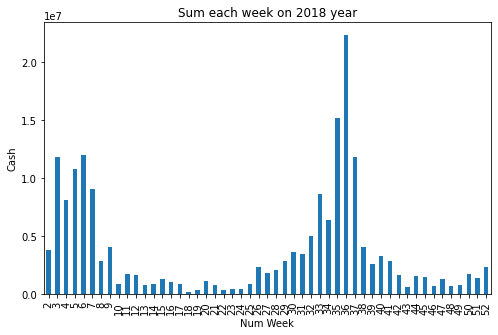

In [ ]:
df[df.year == 2018].groupby('week')['cash'].sum().plot(
    kind = 'bar',
    figsize=(8, 5),
    xlabel='Num Week',
    ylabel='Cash',
    title=f'Sum each week on 2018 year',

)

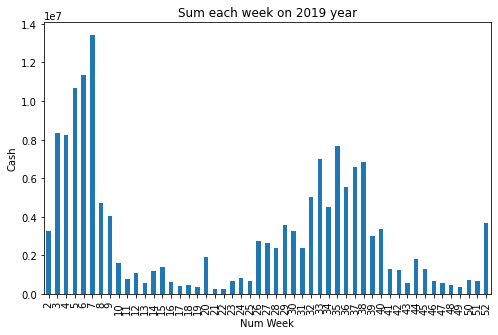

In [ ]:
df[df.year == 2019].groupby('week')['cash'].sum().plot(
    kind = 'bar',
    figsize=(8, 5),
    xlabel='Num Week',
    ylabel='Cash',
    title=f'Sum each week on 2019 year',
)

In [ ]:
df['hour'] = df.date.dt.hour
# df['mean_hour'] = df.groupby(['clear_date', 'hour'])['cash'].transform('mean')
df['median_hour'] = df.groupby(['clear_date', 'hour'])['cash'].transform('median')
df['counts_cash'] = df.groupby(['clear_date'])['cash'].transform('count')
df['moment_counts'] = df['counts_cash'] / df['counts_cash'].shift(1) #0.05
df['count/mean'] = df.counts_cash / df.median_hour

In [ ]:
for i in [5, 7, 14, 28, 30, 60, 90]:
    print('Rolling period:', i)
    df['rolling_mean_'+str(i)] = df.groupby(['clear_date', 'hour'])['cash'].transform(lambda x: x.rolling(1).median()).shift(i)
    df['rolling_std_'+str(i)]  = df.groupby(['clear_date'])['cash'].transform('std').shift(i)
p1 = df.groupby(['year','month','week'])['cash'].transform('median')
p2  = df.groupby(['year', 'month','week', 'day'])['cash'].transform('median')
df['trend_days'] = p2-p1 # 0.009

df.fillna(0, inplace=True)

Rolling period: 5
Rolling period: 7
Rolling period: 14
Rolling period: 28
Rolling period: 30
Rolling period: 60
Rolling period: 90


In [ ]:
drop = ['clear_date', 'date', 'cash','week', 'year', 'counts_cash',]
tr, tr_y, vl, vl_y, vl2, vl2_y, test, test_y = make_data_train(df, test_label, drop, 0.9)

lgb_params = {
    'num_iterations': 1500,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'bagging_fraction': 0.5,
    'subsample_freq': 1,
    'learning_rate':0.03,
    'feature_fraction': 0.5,
    'verbose': -1,
    'early_stopping_round': 50

    }
lgb_params['seed'] = SEED
tr_data = lgb.Dataset(tr, label= tr_y)
tr_data.save_binary('train_data.bin')
tr_data = lgb.Dataset('/content/train_data.bin')
vl_data = lgb.Dataset(vl, label= vl_y)

model = lgb.train(
    lgb_params,
    tr_data,
    valid_sets = [tr_data, vl_data],
    verbose_eval = 100,
)
# lgb.plot_importance(model, figsize=(15,15))
!rm '/content/train_data.bin'

(4555, 24) (4555,) (507, 24) (507,) (106, 24) (106,)
Training until validation scores don't improve for 50 rounds.


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning:

Found `num_iterations` in params. Will use it instead of argument

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:123: UserWarning:

Found `early_stopping_round` in params. Will use it instead of argument



[100]	training's l1: 44337.8	valid_1's l1: 59669
[200]	training's l1: 38012.8	valid_1's l1: 57579.6
[300]	training's l1: 34325.7	valid_1's l1: 56952.9
Early stopping, best iteration is:
[320]	training's l1: 33692.7	valid_1's l1: 56908.5


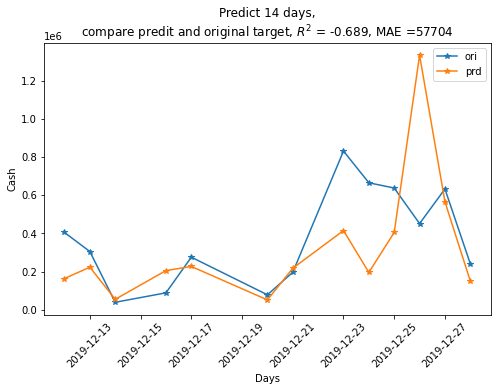

In [ ]:
y_ = model.predict(test)
df_test = df[idx_test:][['clear_date']].reset_index(drop=True)
df_test['ori'] = test_y
df_test['prd'] = abs(y_.astype(float))
ori_label = df_test.groupby('clear_date').ori.sum()
pred_label = df_test.groupby('clear_date').prd.sum()

r2_sum = r2_score(ori_label,pred_label)
mae = mean_absolute_error(test_y, y_)
df_test.groupby('clear_date').sum().plot(
    figsize=(8, 5),
    style = '-*',
    xlabel='Days',
    ylabel='Cash',
    title=f'Predict 14 days,\ncompare predit and original target, $R^2$ = {round(r2_sum, 3)}, MAE ={round(mae)}',
    rot=45
);

In [ ]:
pred_label

clear_date
2019-12-12    1.637643e+05
2019-12-13    2.232272e+05
2019-12-14    5.458863e+04
2019-12-16    2.053140e+05
2019-12-17    2.269692e+05
2019-12-20    5.153021e+04
2019-12-21    2.174734e+05
2019-12-23    4.152279e+05
2019-12-24    1.956682e+05
2019-12-25    4.054258e+05
2019-12-26    1.334874e+06
2019-12-27    5.660151e+05
2019-12-28    1.505228e+05
Name: prd, dtype: float64

In [ ]:
ori_label

clear_date
2019-12-12    405108.369759
2019-12-13    305205.726990
2019-12-14     39112.828434
2019-12-16     88558.353775
2019-12-17    275517.680176
2019-12-20     78353.833847
2019-12-21    196349.546387
2019-12-23    832207.892906
2019-12-24    665703.488159
2019-12-25    638214.563812
2019-12-26    451761.017159
2019-12-27    633272.824783
2019-12-28    240646.001755
Name: ori, dtype: float64

Среднее предсказанное моделью и оригинальные данные

In [ ]:
df_test['prd'].mean(),df_test['prd'].sum(), df_test['ori'].mean(), df_test['ori'].sum()

(39722.64497330312, 4210600.367170131, 45754.831395671055, 4850012.127941132)

Среднее предыдущих 14 дней перед тестом

In [ ]:
df.iloc[idx_test- 106:idx_test].cash.mean(), df.iloc[idx_test- 106:idx_test].cash.sum()

(39015.64453125, 4135657.0)

Ну как сказали в Гарри Поттер шалость удалась, тюнингом признаков и модели мне даже удавалось вывести r2 в плюс, но оставлю текущий вариант.
Мы получили значительно лучшие результаты по сравнению с предыдущей моделью, но у нас по прежнему проблемы с крупными поступлениями.

Спасибо что указали на ошибку в предыдущем ноутбуке, без этого невозможно учиться.


#Errors

TODO:
- анализ декомпозиции ряда,
- критерий Дики-Фуллера,
- преобразования бокса-кокса,
- анализ коррелограммы.

In [ ]:
df = pd.read_excel('/content/drive/MyDrive/TZ/veeroute/Data данные.xlsx')
df = df.iloc[:, 0].str.split(',', expand=True)
df.columns = ['date', 'cash']
df['date'] = pd.to_datetime(df['date'])
df['clear_date'] = df.date.dt.date
df.cash = df.cash.astype('float').round(0).astype(np.int32)  #(6, 261475) (-2147483648, 2147483647)

In [ ]:
dfgroup = df.groupby('clear_date')['cash'].sum()
dfgroup = dfgroup.to_frame().reset_index()

## Компоненты временного ряда
Полезной абстракцией для выбора методов прогнозирования является разбиение временного ряда на систематические и несистематические компоненты.

- систематическая: 
    - Компоненты временного ряда, которые имеют последовательность или повторяемость и могут быть описаны и смоделированы.
- Несистематический:
    - Компоненты временного ряда, которые не могут быть смоделированы напрямую.

Считается, что данный временной ряд состоит из трех систематических компонентов, включая уровень, тренд, сезонность, и одного несистематического компонента, называемого шумом.

Эти компоненты определены следующим образом:
- уровень: Среднее значение в серии.
- тенденция: Увеличение или уменьшение значения в серии.
- Сезонность: Повторяющийся краткосрочный цикл в серии.
- Шум: Случайное изменение в ряду.

Аддитивная модель
y(t) = Level + Trend + Seasonality + Noise
Аддитивная модель является линейной, где изменения во времени последовательно вносятся в одну и ту же величину.

Линейный тренд - это прямая линия.

Линейная сезонность имеет одинаковую частоту (ширина циклов) и амплитуду (высота циклов).

Мультипликативная модель
y(t) = Level * Trend * Seasonality * Noise
Мультипликативная модель является нелинейной, такой как квадратичная или экспоненциальная. Изменения увеличиваются или уменьшаются со временем.

Нелинейный тренд - это изогнутая линия.

Нелинейная сезонность имеет возрастающую или уменьшающуюся частоту и / или амплитуду во времени.

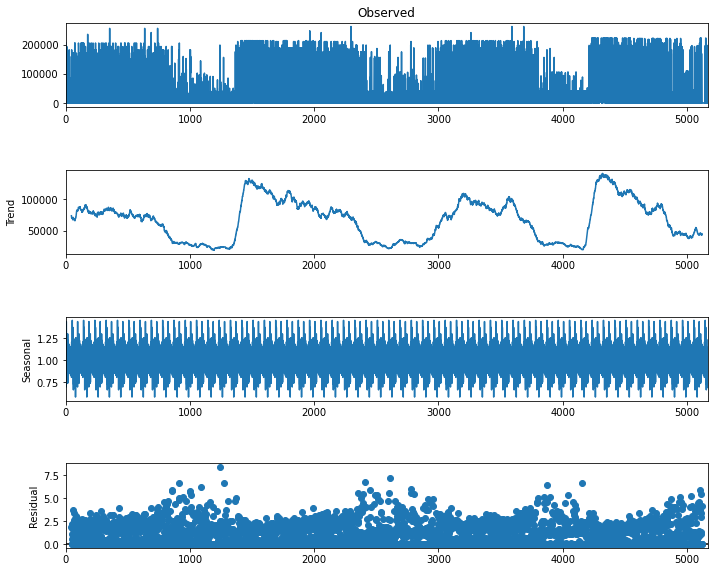

In [ ]:
sd = seasonal_decompose(
    df.cash.values,
    model='multiplicative',
    period=91
).plot()

sd.set_size_inches(11, 9)
plt.show()

У текущих данных нет тренда и сезонности.
Интересно, что когда поступления падают они становятся хаотичными

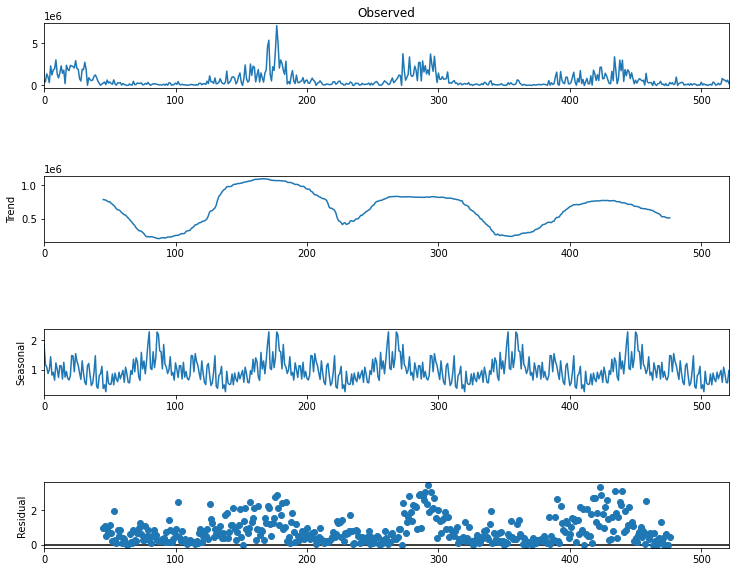

In [ ]:
sd = seasonal_decompose(
    dfgroup.cash.values,
    model='multiplicative',
    period=91
).plot()

sd.set_size_inches(11, 9)
plt.show()

Можно наблюдать нисходящий тренд(постепенно каждый пик становится ниже) и сезонность

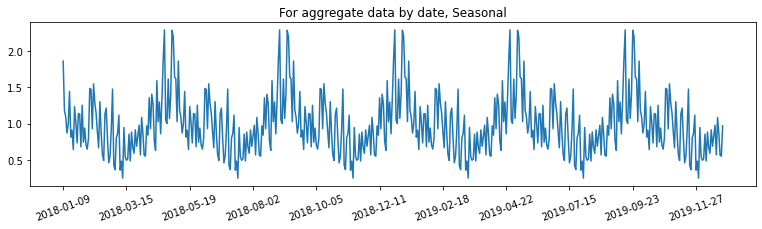

In [ ]:
sd = seasonal_decompose(
    dfgroup.cash.values,
    model='multiplicative',
    period=91
)
tmp_date = []
for i in range(0, 550, 50):
    tmp_date.append(dfgroup.clear_date.values[i])

plt.figure(figsize=(13, 3))
plt.plot(sd.seasonal)
plt.xticks(ticks=range(0, len(dfgroup), 50), labels=tmp_date, rotation=20);
plt.title(
    'For aggregate data by date, Seasonal'
);

Сезонность -  общий систематический линейный или (чаще всего) нелинейный компонент, который изменяется со временем и повторяется. Есть некий цикл 4 месяца рост падение который повторяется.

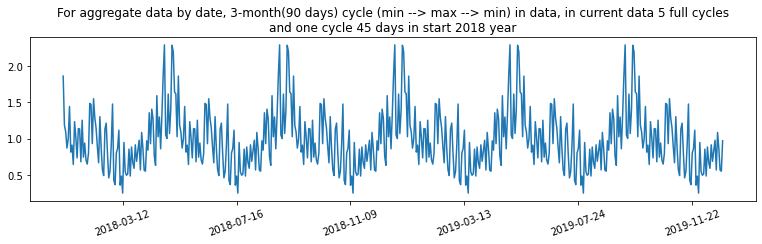

In [ ]:
seas_data = sd.seasonal
cycle = True
tmp_idx = []
while cycle:
    try:
        idx = np.argmin(seas_data)
        tmp_idx.append(idx)
        # print(idx)
        seas_data = seas_data[idx+1:]
    except ValueError:
        cycle = False

tmp_date = []
for i in np.cumsum(tmp_idx)[:6]:
    tmp_date.append(dfgroup.clear_date.values[i])

plt.figure(figsize=(13, 3))
plt.plot(sd.seasonal)
plt.xticks(ticks=np.cumsum(tmp_idx)[:6], labels=tmp_date, rotation=20);
plt.title(
    'For aggregate data by date, 3-month(90 days) cycle (min --> max --> min) in data, in current data 5 full cycles\n'\
    'and one cycle 45 days in start 2018 year'
);

## Boxcox
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.boxcox.html

Что такое преобразование Бокса-Кокса?
Преобразование Бокса Кокса - это преобразование ненормальных зависимых переменных в нормальную форму. Нормальность - важное предположение для многих статистических методов; если ваши данные не соответствуют норме, применение Box-Cox означает, что вы можете выполнить большее количество тестов.

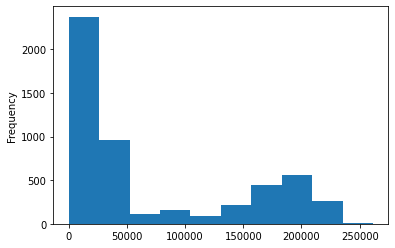

In [ ]:
df.cash.plot(kind= 'hist')

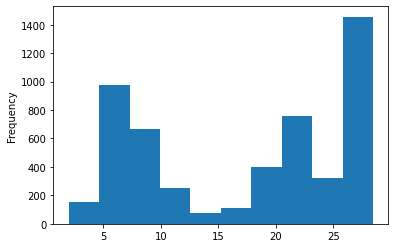

In [ ]:
df['boxcox'] = stats.boxcox(df.cash.values)[0]
df.boxcox.plot(kind= 'hist')

Boxcox делает данные нормальными(нормальное распределение), как уже отмечалось мы видим много значений в начале это небольшие поступления, в середине нормального распределения находятся 68% всех данных , но  у нас нет так, у нас там провал, затем идут более высокие поступления и наконец наибольшие.
Можно сказать что данные распределены по краям, а середина менее насыщена.

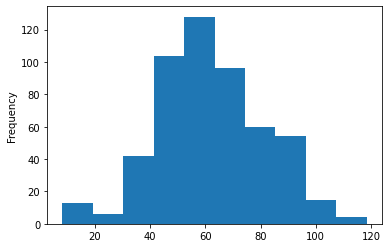

In [ ]:

dfgroup['boxcox'] = stats.boxcox(dfgroup.cash.values)[0]
dfgroup.boxcox.plot(kind= 'hist')

Если сгруппировать по дням и применить преобразования boxcox, то визуально мы увидим нормальное распределение

In [ ]:
"""
In the SciPy implementation of these tests, you can interpret the p value as follows.

p <= alpha: reject H0, not normal.
p > alpha: fail to reject H0, normal.

Тесты предполагают, что выборка была взята из распределения Гаусса.
Технически это называется нулевой гипотезой или H0.
"""

stat, p = stats.shapiro(dfgroup.boxcox.values)
print('Statistics=%.3f, p=%.4f' % (stat, p))
if p > 0.01:print('fail to reject H0, normal')
else:print('reject H0, not normal')

Statistics=0.987, p=0.0001
reject H0, not normal


Тест уверенно отклонил предположение нормальности

## adfuller
https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D1%81%D1%82_%D0%94%D0%B8%D0%BA%D0%B8_%E2%80%94_%D0%A4%D1%83%D0%BB%D0%BB%D0%B5%D1%80%D0%B0

Тест Дики — Фуллера (DF-тест, Dickey — Fuller test) — это методика, которая используется в прикладной статистике и эконометрике для анализа временных рядов для проверки на стационарность. Является одним из тестов на единичные корни (Unit root test). Был предложен в 1979 году Дэвидом Дики и Уэйном Фуллером[1].

Набор данных является стационарным, если его статистические свойства, такие как среднее значение, дисперсия и автокорреляция, не меняются с течением времени.

In [ ]:
adfuller(df.date.values)

(6.022186058262497,
 1.0,
 33,
 5134,
 {'1%': -3.431624361626218,
  '10%': -2.5670697559674203,
  '5%': -2.8621031332717526},
 336108.9482903051)

In [ ]:
#№ https://stackoverflow.com/questions/47349422/how-to-interpret-adfuller-test-results
Нулевая гипотеза: в серии существует нестационарность.
Альтернативная гипотеза: в серии существует стационарность.
- Первая точка данных: 6.022186058262497: критическое значение данных
- Вторая точка данных: 1.0: вероятность того, что нулевая гипотеза не будет отклонена (значение p)
- Третья точка данных: 33: количество лагов, используемых в регрессии для определения t-статистики.
Есть автокорреляция, возвращение нулевым периодам.
- Четвертая точка данных: 5134: Количество наблюдений, использованных в анализе.

Пятая точка данных: {'1%': -3.431624361626218,
                     '10%': -2.5670697559674203,
                     '5%': -2.8621031332717526}: значения T, соответствующие тесту Адфуллера.

Поскольку критическое значение 6.022186058262497 > -3,4, -2,56, -2,86
(t-значения при доверительных интервалах 1%, 5% и 10%), нулевая гипотеза не может быть отклонена.
Значит, в ваших данных есть нестационарность

Также p-значение 1.0 > 0,05 (если мы возьмем 5% уровень значимости или 95% доверительный интервал), 
нулевая гипотеза не может быть отклонена.

Следовательно, данные нестационарны (это означает, что они связаны со временем).

## autocorrelation plot (or correlogram)

Область синего затенения **называется полосой погрешности**.
Все, что находится внутри полосы ошибок, не имеет статистической значимости.


https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8

https://gist.github.com/I-Tingya/c37123f69ef7b4d2d8ff2d831661cae1#file-ar-ipynb

https://gist.github.com/I-Tingya/457ee85af6e62c9621588f9b79fe6de6#file-ma-ipynb

Процесс авторегрессии (AR), временной ряд называется AR, когда текущее значение временного ряда может быть получено с использованием предыдущих значений того же временного ряда, то есть текущее значение представляет собой средневзвешенное значение его прошлых значений.

In [ ]:
Мы можем вычислить корреляцию для наблюдений временного ряда с наблюдениями с предыдущими временными шагами,
называемыми лагами. Поскольку корреляция наблюдений временного ряда вычисляется со значениями того же ряда
в предыдущие моменты времени, это называется последовательной корреляцией или автокорреляция.

График автокорреляции временного ряда по запаздыванию называется функцией автокорреляции или 
аббревиатурой ACF.Этот график иногда называют коррелограммой или графиком автокорреляции.

Ниже приведен пример расчета и построения графика автокорреляции для минимальных дневных температур 
с использованием функции plot_acf () из библиотеки statsmodels.

При выполнении примера создается двухмерный график, показывающий значение запаздывания по оси x и 
корреляцию по оси y между -1 и 1.
Доверительные интервалы изображены в виде конуса.По умолчанию для него установлен доверительный интервал 95%,
что позволяет предположить, что значения корреляции за пределами этого кода, скорее всего, являются корреляцией, а не статистической случайностью.


Функция частичной автокорреляции
Частичная автокорреляция - это сводка отношений между наблюдением во временном ряду с наблюдениями
на предыдущих временных шагах с удаленными взаимосвязями промежуточных наблюдений.

Частичная автокорреляция при лаге k - это корреляция, которая возникает после устранения влияния любых 
корреляций из-за членов с более короткими лагами.

### ACF

Временной ряд может иметь такие компоненты, как тренд, сезонность, цикличность и остаток. ACF учитывает все эти компоненты при нахождении корреляций, поэтому это «полный график автокорреляции».

Мы находим оптимальные характеристики или порядок процесса MA с помощью графика ACF, поскольку, будучи процессом MA, он не имеет сезонных и трендовых компонентов, поэтому мы получаем только остаточную связь с лагами временных рядов на графике ACF.

not group

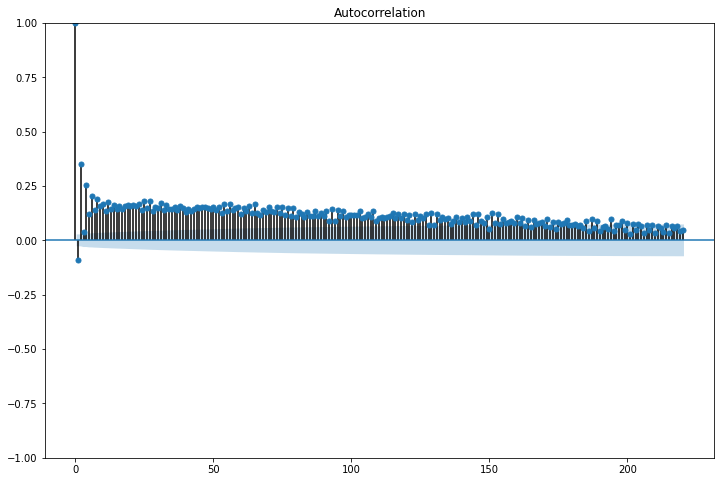

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(12,8))
plot_acf(df.cash.values, lags=220, ax = ax);

lag 200, 91~14 days, 30 days lag


```
14/91
>>0.15
200*0.15
>> 30.0
```



group

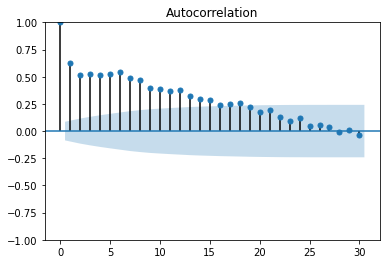

In [ ]:
plot_acf(dfgroup.cash.values, lags=30);

get 1, 6 or 15 day 

### PACF

PACF - это функция частичной автокорреляции. По сути, вместо того, чтобы находить корреляции присутствия с лагами, такими как ACF, он находит корреляцию остатков (которые остаются после удаления эффектов, которые уже объясняются более ранним лагом (ами)) со следующим значением лага, следовательно, «частичным», а не «полным». 'поскольку мы удаляем уже найденные варианты, прежде чем найдем следующую корреляцию. Таким образом, если в остатке есть какая-либо скрытая информация, которую можно смоделировать с помощью следующего лага, мы можем получить хорошую корреляцию, и мы сохраним эту следующую задержку как особенность при моделировании.

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



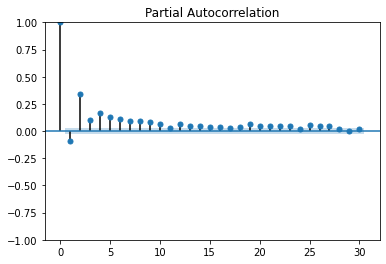

In [ ]:
plot_pacf(df.cash.values, lags=30);

get 1,2 4 lags or 10 lags

/usr/local/lib/python3.7/dist-packages/statsmodels/graphics/tsaplots.py:353: FutureWarning:

The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.



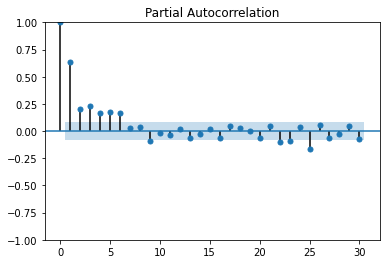

In [ ]:
plot_pacf(dfgroup.cash.values, lags=30);

get 1,3,9,25 lags or 6 lags - 7 lags

grouped data:

    ACF = MA, PACF= AR >> ARIMA
    MA = 7
    AR = 15
    ARIMA= (15, 2, 7)


# TODO
    -  make new model
    with:
        boxcox train and predict or after user inv_boxcox
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.special.inv_boxcox.html
        make lags by ACF&FACF
        make features seasoanly
        make skip trend
        (Если в наборе данных есть очевидная тенденция, сначала нам придется снять ее с тренда, используя разность. Обычно в этом отношении используется разность с одним запаздыванием)


make two part:
- first i save old model and change lags, boxcox for check whose the best 
- second make new idea with param TODO

## Part 1

In [24]:
def time_features(df: pd.DataFrame) -> None:
    df.date = pd.to_datetime(df.date, utc=True)
    attr = [      
            'day',
            'month',
            # 'week',
            "dayofweek",
            # "year",
            'quarter'
            ]    
    for at in attr:
        dtype = np.int16 if at == "year" else np.int8
        df[at] = getattr(df.date.dt, at).astype(dtype)


def viz_result(
    data: pd.DataFrame,
    title_txt: str,
    multi: bool = False
) -> None:
    fig, ax = plt.subplots(5, 2, figsize = (15, 15))
    for i, d in enumerate(data):
        ax[i, 0].scatter(range(len(d.ori)), d.ori, c = 'b', label = 'ori')
        ax[i, 0].scatter(range(len(d.prd)), d.prd, c = 'r', label = 'prd') 
        if multi:
            ax[i, 0].scatter(range(len(d.prd_multi)), d.prd_multi, c = 'g', label = 'prd_multi') 
        d = d.groupby('clear_date').sum()
        if multi:
            ax[i, 1].plot(d.index, d.ori, '-b', d.index, d.prd, '--*r',  d.index, d.prd_multi, '-g')
            ax[i, 1].legend(['ori', 'prd', 'multi_prd'])
        else:
            ax[i, 1].plot(d.index, d.ori, '-b', d.index, d.prd, '--*r')
            ax[i, 1].legend(['ori', 'prd'])
        ax[0, 0].set_title('By values in each days (2 week)')
        ax[0, 1].set_title('Gruppend by days')
        ax[i, 1].tick_params(labelrotation=15, labelsize='small')     
    
    plt.subplots_adjust(wspace=0.07)
    plt.suptitle(title_txt, fontsize=18, y=0.95);


def make_data(
    path: str,
    week_start: pd._libs.tslibs.timestamps.Timestamp,
    week_end: pd._libs.tslibs.timestamps.Timestamp, 
    fill_test: int = 0,
    boxcox: bool = False
) -> tuple:
    """
    path : str path to data file
    week_start: int start test data
    week_end: int ends test data
    for test we set cash to zero or fill another values
    return: pd.DataFrame,  index satrt test, original label to test not changed   
    """
    col_name = ['date', 'cash']
    df = pd.read_excel(path)
    df = df.iloc[:, 0].str.split(',', expand=True)   
    df.columns =  col_name
    df['date'] = pd.to_datetime(df['date'])
    df['clear_date'] = df.date.dt.date
    df.cash = df.cash.astype('float32')
    df['week'] = df.date.dt.week
    df['year'] = df.date.dt.year
    param = (df.week >= week_start) & (df.week <= week_end) & (df.year == 2019)
    test_label = df[param].cash.values    
    idx_test, idx_test_end = df[param].index[0], df[param].index[-1]
    if boxcox:
        if fill_test <= 0: fill_test = 1 # skip error boxcox trasform
        df.loc[param, 'cash'] = fill_test
        # df.cash, lambda_ = stats.boxcox(df.cash.values)
        # print(f'Lambda boxcox: {lambda_}')
        df.cash = boxcox_special(df.cash.values, 0.1222426551726705)        
    else:
        df.loc[param, 'cash'] = fill_test
    # +1 because because not include 5 [:5] >> 1,2,3,4, bool include
    return df.iloc[:idx_test_end+1], idx_test, test_label


def make_features(
    start:int,
    end:int, 
    lags: int,
    lags_param: list,
    boxcox: bool = False
) -> None:
    df, idx_test, test_label = make_data(PATH, start, end,  0, boxcox)

    time_features(df)
    df['hour'] = df.date.dt.hour
    df['median_hour'] = df.groupby(['clear_date', 'hour'])['cash'].transform('median')
    df['ewm_trebd_var']  = df.median_hour.ewm(alpha=0.5, adjust=False).var()
    df['counts_cash'] = df.groupby(['clear_date'])['cash'].transform('count')
    df['mean_hour_shift'] = df.groupby(['clear_date', 'hour'])['cash'].transform('mean').shift(lags)
    df['minn'] = df.groupby(['clear_date', 'hour'])['cash'].transform(lambda x: x.min()).shift(lags)
    df['maxx'] = df.groupby(['clear_date', 'hour'])['cash'].transform(lambda x: x.max()).shift(lags)
    # df['std'] = df.groupby(['clear_date'])['mean_hour_shift'].transform('std')
    df['min/maxx'] = df.groupby(['clear_date'])['mean_hour_shift'].transform(lambda x: x.min() / 1 + x.max())

    for i in lags_param:
        print('Lag period:', i)
        df['lag_mean_'+str(i)] = df.groupby(['clear_date', 'hour'])['cash'].transform(lambda x: x.mean()).shift(i)
        df['lag_std_'+str(i+1)]  = df.groupby(['clear_date', 'hour'])['cash'].transform(lambda x: x.std()).shift(i)
    df.fillna(0, inplace=True)
    return df, idx_test, test_label


def lgb_model(
    train,
    train_y,
    valid,
    valid_y,
    lgb_params: dict
) -> lgb.basic.Booster:

    lgb_params['seed'] = SEED
    tr_data = lgb.Dataset(train, label= train_y)
    tr_data.save_binary('train_data.bin')
    tr_data = lgb.Dataset('/content/train_data.bin')
    vl_data = lgb.Dataset(valid, label= valid_y)

    model = lgb.train(
        lgb_params,
        tr_data,
        valid_sets = [tr_data, vl_data],
        verbose_eval = 1000
    )
    !rm '/content/train_data.bin'
    return model


DATE_TEST = '2019-12-11'
PATH = '/content/drive/MyDrive/TZ/veeroute/Data данные.xlsx'


lgb_params = {
    'num_iterations': 1500,
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'bagging_fraction': 0.5,
    'subsample_freq': 1,
    'learning_rate':0.03,
    'feature_fraction': 0.5,
    'early_stopping_round': 50

    }

## find param

In [ ]:
for l in [160, 170,180,200,220, 230]:
    for i in range(3, 10):
        lags_param =np.random.choice([0,1,2,3,6,8,12,18,19,27], i,replace=False)
        boxcox = True
        df, idx_test, test_label =  make_features(
            50,
            52,
            lags = l,
            lags_param = lags_param,
            boxcox = boxcox
        )
        drop = ['clear_date', 'date', 'cash','week', 'year']
        tr, tr_y, vl, vl_y, vl2, vl2_y, test, test_y = make_data_train(df, test_label, drop, 0.8, True)
        model = lgb_model(tr, tr_y, vl, vl_y, lgb_params)
        y_ = model.predict(vl2)
        mae = mean_absolute_error(vl2_y, y_)
        r2 = r2_score(vl2_y, y_)
        print(f'Lags: {l}, lags param: {lags_param}')
        print('Result predict model on valid data Rsquare: %.3f, mae: %.1f' % (r2, mae))
        y_ = model.predict(test)
        df_test = df[idx_test:][['clear_date']].reset_index(drop=True)
        if boxcox:
            # _, lambda_ = stats.boxcox(test_y, )
            # print('lam', lambda_)
            df_test['ori'] = boxcox_special(test_y, 0.1222426551726705)
            df_test['prd'] = abs(y_.astype(float))
            # df_test['prd_inv'] = inv_boxcox(abs(y_.astype(float)), 0.1222426551726705)
            # df_test['ori_'] = test_y
        else:          
            df_test['ori'] = test_y
            df_test['prd'] = abs(y_.astype(float))
            df_test['prd_multi'] = abs(y_.astype(float)) * 9.19
            pred_label_multi = df_test.groupby('clear_date').prd_multi.sum()

        ori_label = df_test.groupby('clear_date').ori.sum()
        pred_label = df_test.groupby('clear_date').prd.sum()       
        r2_sum = r2_score(ori_label, pred_label)
        if boxcox:
            r2_sum_multi = 0
        else:
            r2_sum_multi = r2_score(ori_label, pred_label_multi)
        print('Result predict model on test data Rsquare: %.3f, multi: %.3f' % (r2_sum, r2_sum_multi))    

### not boxcox

In [ ]:
rscore, rscore_m, maescore = [],[],[]
tmp_df = []
for start, end in  zip(list(range(42, 52, 2)), list(range(44, 54, 2))):    
    lags_param =  [3, 2, 18, 6, 0, 1 ,12 ,19, 8] 
    lag =170
    df, idx_test, test_label =  make_features(
        start,
        end,
        lags = lag,
        lags_param = lags_param
        )
    print(f'Week stat: {start} week ends: {end}, shape: {df.shape}')
    drop = ['clear_date', 'date', 'cash','week', 'year']
    tr, tr_y, vl, vl_y, vl2, vl2_y, test, test_y = make_data_train(df, test_label, drop, 0.8, True)
    model = lgb_model(tr, tr_y, vl, vl_y, lgb_params)
    y_ = model.predict(test)
    df_test = df[idx_test:][['clear_date']].reset_index(drop=True)
    df_test['ori'] = test_y
    df_test['prd'] = abs(y_.astype(float))
    df_test['prd_multi'] = abs(y_.astype(float)) * 9.19 # np.mean(list(np.mean(tmp_df[i].prd / tmp_df[i].ori) for i in range(5)))
    ori_label = df_test.groupby('clear_date').ori.sum()
    pred_label = df_test.groupby('clear_date').prd.sum()
    pred_label_multi = df_test.groupby('clear_date').prd_multi.sum()    
    r2_sum = r2_score(ori_label, pred_label)
    mae = mean_absolute_error(test_y, y_)
    r2_sum_multi = r2_score(ori_label, pred_label_multi)
    print('Result predict model on test data Rsquare: %.3f, multi: %.3f, mae: %.3f' % (r2_sum, r2_sum_multi, mae))
    rscore.append(r2_sum)
    rscore_m.append(r2_sum_multi)
    maescore.append(mae)
    tmp_df.append(df_test)
print(f'Mean: r2 = {np.mean(rscore)} r2_multi = {np.mean(rscore_m)}')

Lag period: 3
Lag period: 2
Lag period: 18
Lag period: 6
Lag period: 0
Lag period: 1
Lag period: 12
Lag period: 19
Lag period: 8
Week stat: 42 week ends: 44, shape: (4967, 35)
(3917, 30) (3917,) (490, 30) (490,) (70, 30) (70,)
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[410]	training's l1: 31756.8	valid_1's l1: 25635.7
Result predict model on test data Rsquare: -0.685, multi: 0.561, mae: 54897.408
Lag period: 3
Lag period: 2
Lag period: 18
Lag period: 6
Lag period: 0
Lag period: 1
Lag period: 12
Lag period: 19
Lag period: 8
Week stat: 44 week ends: 46, shape: (5020, 35)
(3948, 30) (3948,) (493, 30) (493,) (85, 30) (85,)
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[428]	training's l1: 31208.4	valid_1's l1: 27524
Result predict model on test data Rsquare: -0.797, multi: 0.451, mae: 44215.482
Lag period: 3
Lag period: 2
Lag period: 18
Lag period: 6
Lag period: 0
Lag period: 1
Lag per

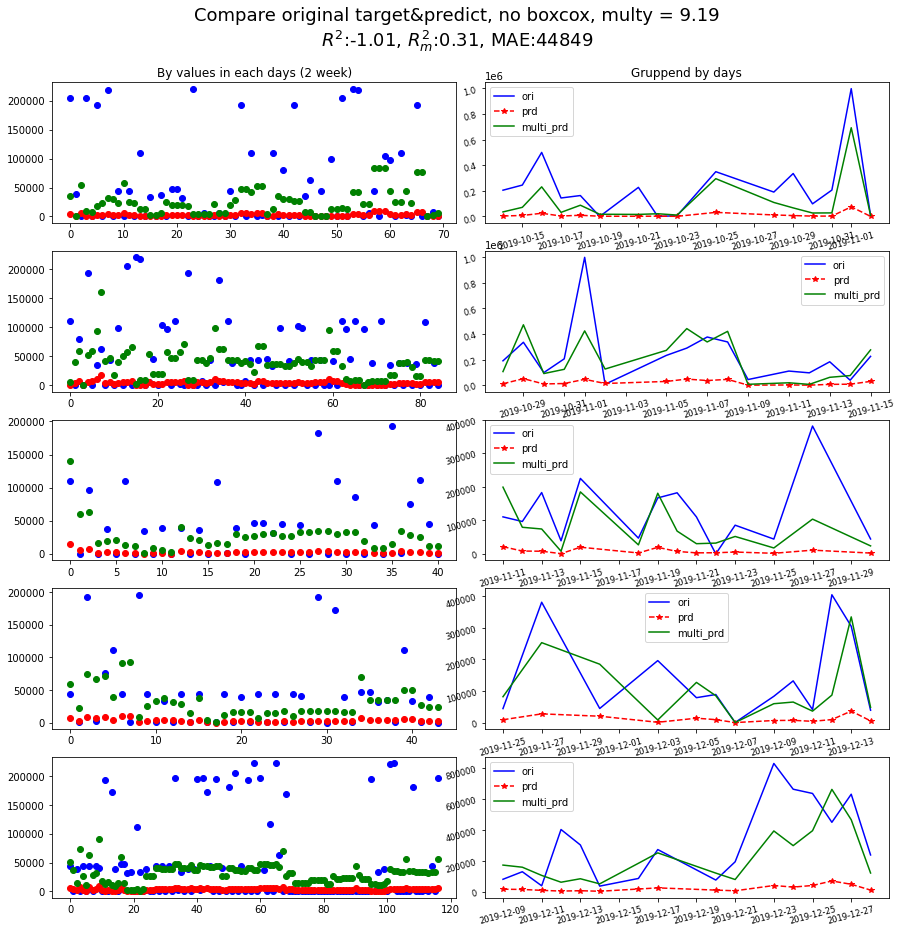

In [ ]:
viz_result(
    tmp_df,
    title_txt = "Compare original target&predict, no boxcox, multy = 9.19\n"\
               f"$R^2$:{round(np.mean(rscore), 2)}, $R^2_m$:{round(np.mean(rscore_m),2)}, "\
               f"MAE:{round(np.mean(maescore))}",
    multi = True)

###boxcox

In [ ]:
rscore, rscore_m = [],[]
tmp_df = []
for start, end in  zip(list(range(42, 52, 2)), list(range(44, 54, 2))):    
    lags_param =  [18,  3,  1,  8] 
    lag =200
    boxcox = True
    df, idx_test, test_label =  make_features(
        start,
        end,
        lags = lag,
        lags_param = lags_param,
        boxcox = boxcox
        )
    print(f'Week stat: {start} week ends: {end}, shape: {df.shape}')
    drop = ['clear_date', 'date', 'cash','week', 'year']
    tr, tr_y, vl, vl_y, vl2, vl2_y, test, test_y = make_data_train(df, test_label, drop, 0.8, True)
    model = lgb_model(tr, tr_y, vl, vl_y, lgb_params)
    y_ = model.predict(test)
    df_test = df[idx_test:][['clear_date']].reset_index(drop=True)
    df_test['ori'] = boxcox_special(test_y, 0.1222426551726705)
    df_test['prd'] = abs(y_.astype(float))

    ori_label = df_test.groupby('clear_date').ori.sum()
    pred_label = df_test.groupby('clear_date').prd.sum()
  
    r2_sum = r2_score(ori_label, pred_label)

    print('Result predict model on test data Rsquare: %.3f' % (r2_sum))
    rscore.append(r2_sum)
    tmp_df.append(df_test)
print(f'Mean: r2 = {np.mean(rscore)}, std = {np.std(rscore)}')

Lag period: 18
Lag period: 3
Lag period: 1
Lag period: 8
Week stat: 42 week ends: 44, shape: (4967, 25)
(3917, 20) (3917,) (490, 20) (490,) (70, 20) (70,)
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[397]	training's l1: 5.28317	valid_1's l1: 5.11619
Result predict model on test data Rsquare: 0.587
Lag period: 18
Lag period: 3
Lag period: 1
Lag period: 8
Week stat: 44 week ends: 46, shape: (5020, 25)
(3948, 20) (3948,) (493, 20) (493,) (85, 20) (85,)
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[647]	training's l1: 4.62306	valid_1's l1: 4.99133
Result predict model on test data Rsquare: 0.454
Lag period: 18
Lag period: 3
Lag period: 1
Lag period: 8
Week stat: 46 week ends: 48, shape: (5041, 25)
(4000, 20) (4000,) (500, 20) (500,) (41, 20) (41,)
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[667]	training's l1: 4.62727	valid_1's l1: 5

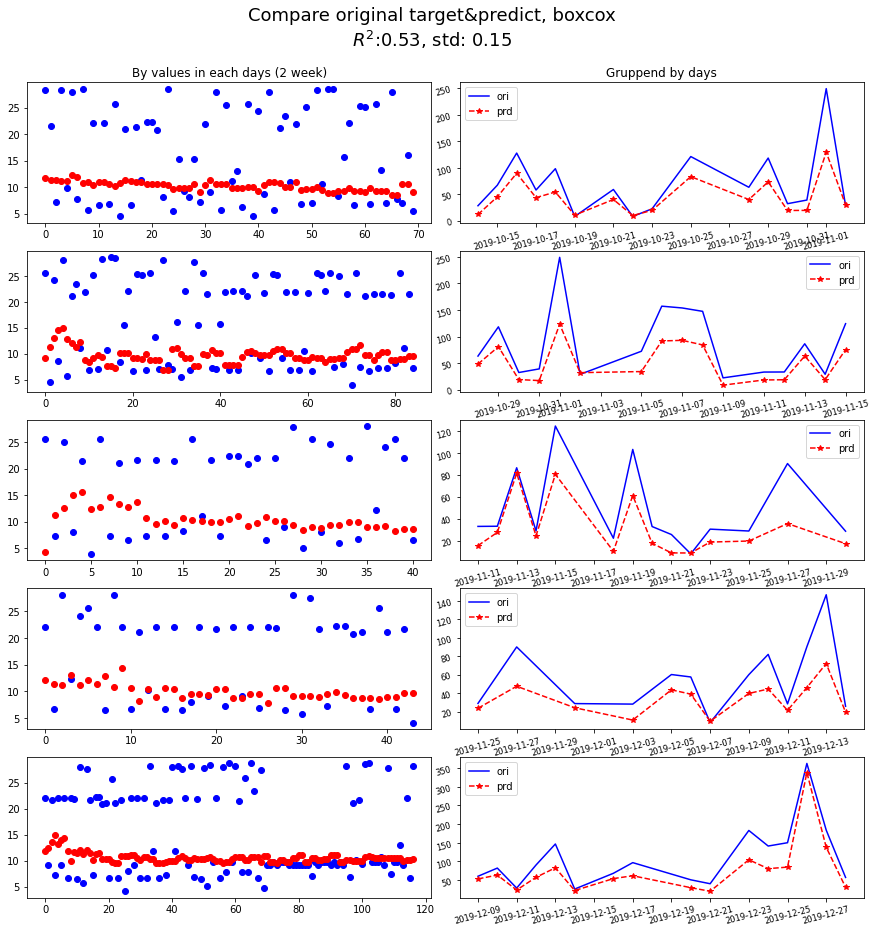

In [ ]:
viz_result(
    tmp_df,
    title_txt = "Compare original target&predict, boxcox\n"\
                f"$R^2$:{round(np.mean(rscore), 2)}, std: {round(np.std(rscore), 2)}",
    multi = False)

##Part 2

https://www.bounteous.com/insights/2020/09/15/forecasting-time-series-model-using-python-part-one/

make same new idea features

In [ ]:
"""
interval 45(~300) and 90(~600) day
"""

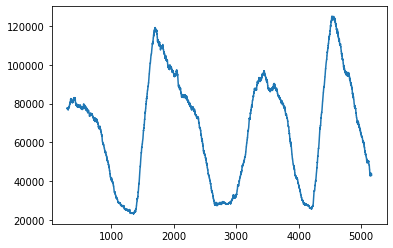

In [11]:
df.cash.rolling(300).mean().plot()

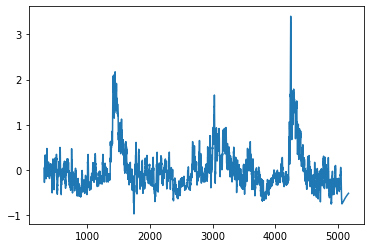

In [125]:
df['detrand'] = (df.cash - df.cash.rolling(300).mean()) / df.cash.rolling(300).std()
df.detrand.rolling(14).mean().plot()

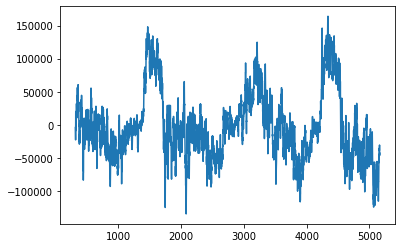

In [126]:
df['differencing'] = df.cash - df.cash.shift(300)
df.differencing.rolling(14).mean().plot()

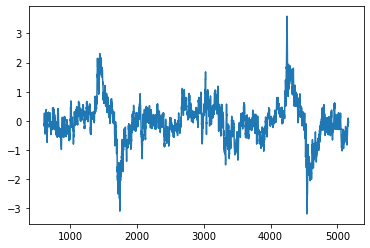

In [127]:
df['comb_dd'] = df.detrand - df.detrand.shift(300)
df.comb_dd.rolling(14).mean().plot()

In [38]:
def add_new_feature(
    roll: int,
    shif:int, 
    drop_f: list = []
) -> None:
    df['detrand'] = (df.cash - df.cash.rolling(roll).mean()) / df.cash.rolling(roll).std()
    df['differencing'] = df.cash - df.cash.shift(shif)
    df['comb_dd'] = df.detrand - df.detrand.shift(shif)
    if len(drop_f) >= 1:
        df.drop(drop_f, axis = 1, inplace=True)
    df.fillna(0, inplace=True)

new_f = ['detrand','differencing','comb_dd']

In [122]:
# for r in [150, 300, 450, 600, 750]:
#     for s in [150, 300, 450, 600, 750]:
#         print('----', r, s)

rscore, rscore_m, maescore = [],[],[]
tmp_df = []
for start, end in  zip(list(range(42, 52, 2)), list(range(44, 54, 2))):    
    lags_param =  [3, 2, 18, 6, 0, 1 ,12 ,19, 8] 
    lag =170
    df, idx_test, test_label =  make_features(
        start,
        end,
        lags = lag,
        lags_param = lags_param
        )
    print(f'Week stat: {start} week ends: {end}, shape: {df.shape}')
    drop = ['clear_date', 'date', 'cash','week', 'year',  'lag_std_19',  'month']
    add_new_feature(450, 300, ['detrand'])
    tr, tr_y, vl, vl_y, vl2, vl2_y, test, test_y = make_data_train(df, test_label, drop, 0.8, True)
    model = lgb_model(tr, tr_y, vl, vl_y, lgb_params)
    y_ = model.predict(test)
    df_test = df[idx_test:][['clear_date']].reset_index(drop=True)
    df_test['ori'] = test_y
    df_test['prd'] = abs(y_.astype(float))
    df_test['prd_multi'] = abs(y_.astype(float)) * 3 # np.mean(list(np.mean(tmp_df[i].prd / tmp_df[i].ori) for i in range(5)))
    ori_label = df_test.groupby('clear_date').ori.sum()
    pred_label = df_test.groupby('clear_date').prd.sum()
    pred_label_multi = df_test.groupby('clear_date').prd_multi.sum()    
    r2_sum = r2_score(ori_label, pred_label)
    mae = mean_absolute_error(test_y, y_)
    r2_sum_multi = r2_score(ori_label, pred_label_multi)
    print('Result predict model on test data Rsquare: %.3f, multi: %.3f, mae: %.3f' % (r2_sum, r2_sum_multi, mae))
    rscore.append(r2_sum)
    rscore_m.append(r2_sum_multi)
    maescore.append(mae)
    tmp_df.append(df_test)
print(f'Mean: r2 = {np.mean(rscore)} r2_multi = {np.mean(rscore_m)}')

Lag period: 3
Lag period: 2
Lag period: 18
Lag period: 6
Lag period: 0
Lag period: 1
Lag period: 12
Lag period: 19
Lag period: 8
Week stat: 42 week ends: 44, shape: (4967, 35)
(3917, 30) (3917,) (490, 30) (490,) (70, 30) (70,)
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[291]	training's l1: 15759.8	valid_1's l1: 11655.5
Result predict model on test data Rsquare: -0.336, multi: 0.451, mae: 53236.254
Lag period: 3
Lag period: 2
Lag period: 18
Lag period: 6
Lag period: 0
Lag period: 1
Lag period: 12
Lag period: 19
Lag period: 8
Week stat: 44 week ends: 46, shape: (5020, 35)
(3948, 30) (3948,) (493, 30) (493,) (85, 30) (85,)
Training until validation scores don't improve for 50 rounds.
Early stopping, best iteration is:
[479]	training's l1: 13297.4	valid_1's l1: 11900
Result predict model on test data Rsquare: -0.215, multi: 0.460, mae: 42528.702
Lag period: 3
Lag period: 2
Lag period: 18
Lag period: 6
Lag period: 0
Lag period: 1
Lag per

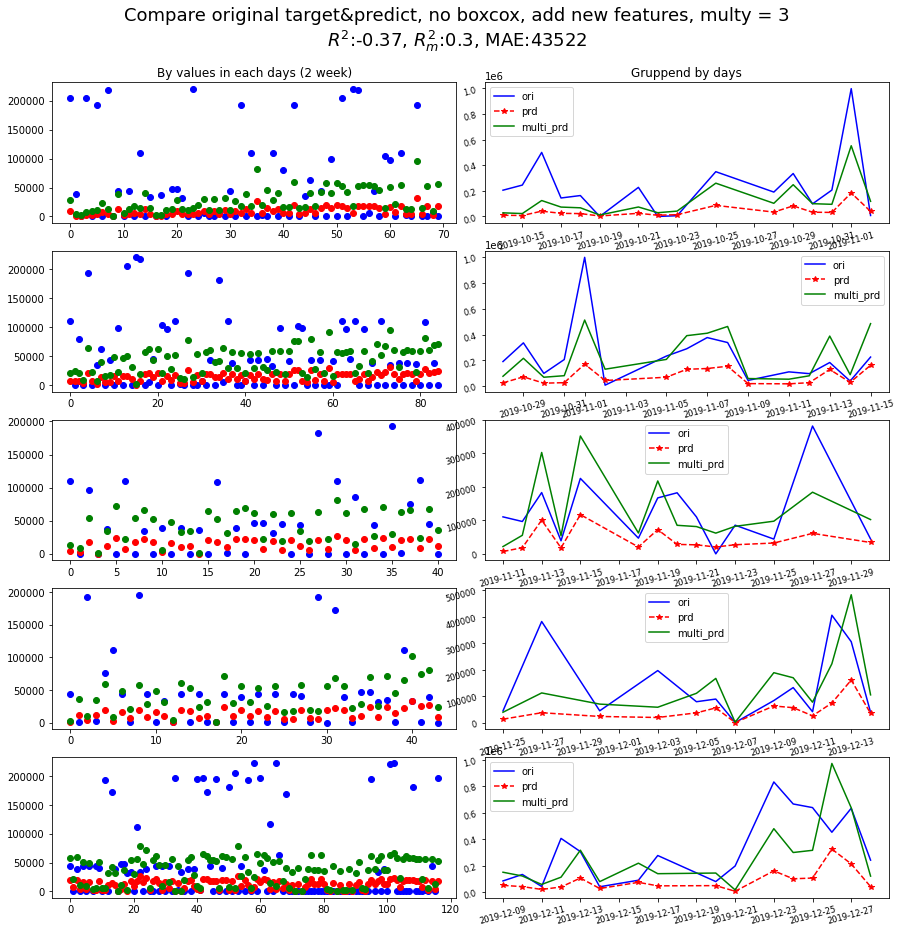

In [123]:
viz_result(
    tmp_df,
    title_txt = "Compare original target&predict, no boxcox, add new features, multy = 3\n"\
               f"$R^2$:{round(np.mean(rscore), 2)}, $R^2_m$:{round(np.mean(rscore_m),2)}, "\
               f"MAE:{round(np.mean(maescore))}",
    multi = True)